In [2]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
import statsmodels.api as sm

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
# import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [ ]:
pwd

In [3]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]


# r13
r13 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

# APOKASC
# kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')

# Diane Feuillet
pdfout = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/LMC_DR16_all_PDF.fits.gz', 1)
_, r13_ind, pdfout_ind = np.intersect1d(r13['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

In [4]:
parsec.columns

<TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Jmag','Hmag','Ksmag')>

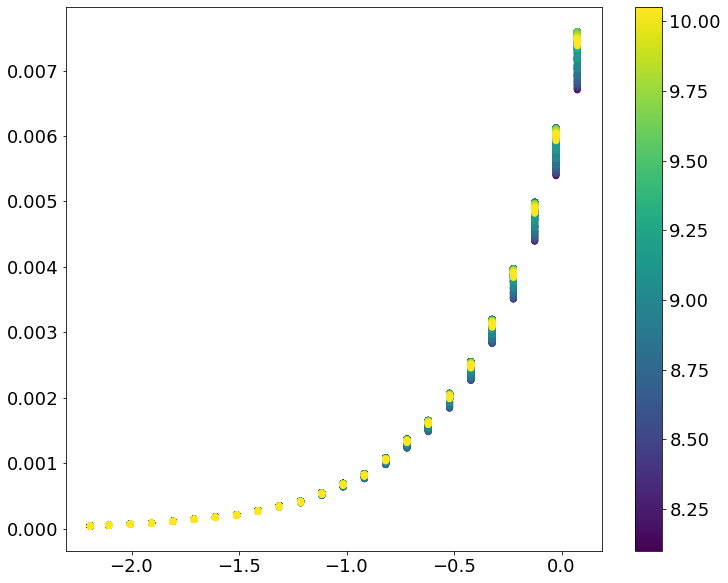

In [5]:
plt.figure(figsize=[12,10])
plt.scatter(parsec['MH'],parsec['Xo'],c=parsec['logAge'])
plt.colorbar()

In [6]:
###############################
### Some Calcuations Needed ###
###############################

### Convert RA DEC to MS L B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i]-360<-180:
        ms_lg[i] += 360.0

### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

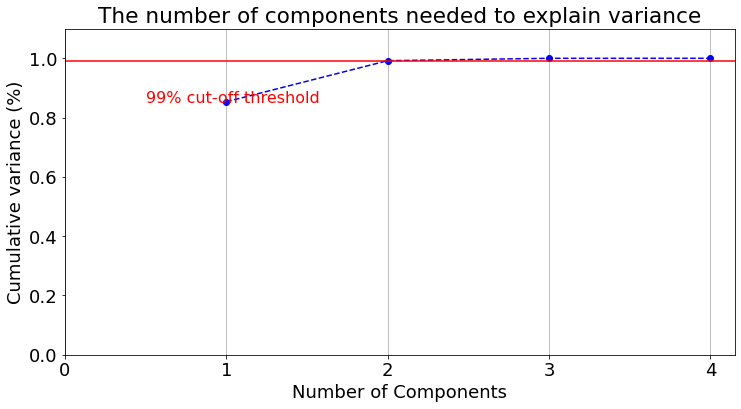

In [7]:
### Setup 
data = np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T

### Determine Number of factors
pca = PCA(n_components=4).fit(data)#_rescaled)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.85, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [8]:
### Find all models

#transform data to new basis
new_data = PCA(n_components=3).fit(data).transform(data)

#create new variables

# linear terms
x1 = new_data[:,0]
x2 = new_data[:,1]
x3 = new_data[:,2]

# linear int
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x23 = np.multiply(x2,x3)

# squares
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2

# cubes
x1cu = x1**3
x2cu = x2**3
x3cu = x3**3


#find all possible models
models = []
models_str = []

all_var_str = ['x1','x2','x3','x12','x13','x23','x1sq','x2sq','x3sq','x1cu','x2cu','x3cu']
all_var = [x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x1cu,x2cu,x3cu]

for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

### Fit All Models

import statsmodels.api as sm 

all_params = []
summaries = []
max_resid = []
mads = []
resids = []
predict = []
ll = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    summaries.append(model.summary())
    predictions = model.predict(pmodl)
    predict.append(predictions)
    residual = predictions - parsec['logAge']
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    mads.append(afunc.mad(residual))
    ll.append(model.llf)

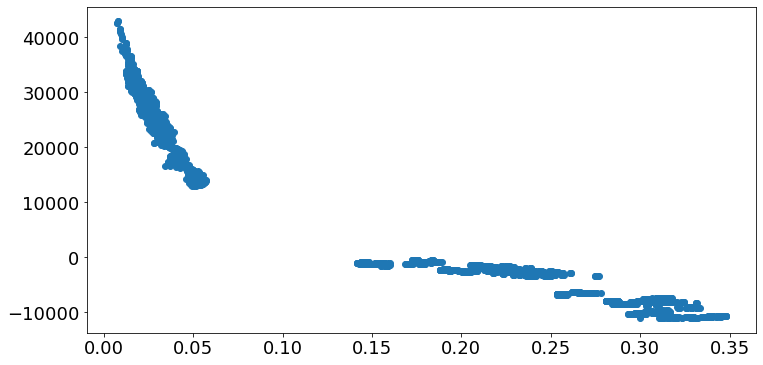

In [9]:
plt.scatter(mads,ll)

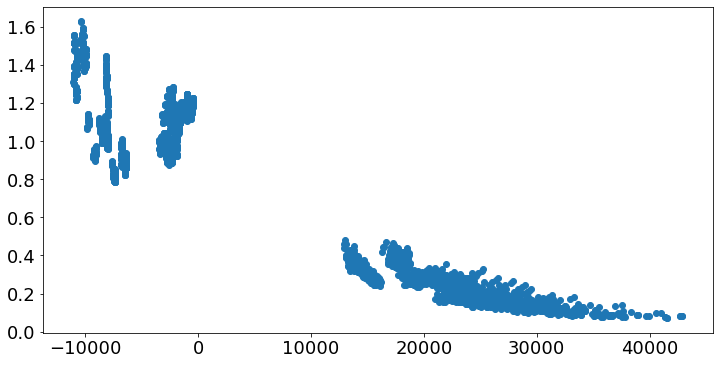

In [10]:
plt.scatter(ll,max_resid)

In [11]:
# models_str[np.asarray(max_resid).argmin()]

In [12]:
models_str[np.asarray(mads).argmin()]

array(['x1', 'x2', 'x3', 'x12', 'x13', 'x23', 'x1sq', 'x2sq', 'x3sq',
       'x1cu', 'x2cu'], dtype='<U4')

In [13]:
# models_str[np.asarray(mads).argmin()]

In [14]:
models_str[np.asarray(max_resid).argmin()]

array(['x1', 'x2', 'x3', 'x12', 'x13', 'x23', 'x1sq', 'x2sq', 'x3sq',
       'x1cu', 'x3cu'], dtype='<U4')

In [15]:
# parsimonious = np.array([x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x1cu,x2cu,x3cu]).T
# parsimonious = sm.add_constant(parsimonious)
# parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
# parsimonious_predictions = parsimonious_model.predict(parsimonious)
# parsimonious_residual = parsimonious_predictions - parsec['logAge']
# print(afunc.mad(parsimonious_residual))
# parsimonious_summary = parsimonious_model.summary()
# print(parsimonious_summary)
# print(np.asarray(parsimonious_model.params))
# # print(models_str[np.asarray(ll).argmax()])

In [16]:
# parsimonious = np.array([x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x1cu,x2cu,x3cu]).T
# parsimonious = sm.add_constant(parsimonious)
# parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
# parsimonious_predictions = parsimonious_model.predict(parsimonious)
# parsimonious_residual = parsimonious_predictions - parsec['logAge']
# print(afunc.mad(parsimonious_residual))
# parsimonious_summary = parsimonious_model.summary()
# print(parsimonious_summary)
# print(np.asarray(parsimonious_model.params))
# print(models_str[np.asarray(ll).argmax()])

In [17]:
# parsimonious = np.array([x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu]).T
# parsimonious = sm.add_constant(parsimonious)
# parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
# parsimonious_predictions = parsimonious_model.predict(parsimonious)
# parsimonious_residual = parsimonious_predictions - parsec['logAge']
# print(afunc.mad(parsimonious_residual))
# parsimonious_summary = parsimonious_model.summary()
# print(parsimonious_summary)
# print(np.asarray(parsimonious_model.params))
# # print(models_str[np.asarray(ll).argmax()])

In [18]:
# ### Final Age Model

# def find_ages(z1,z2,z3):
#     # all of them NO
# #     p=[ 9.38632004e+00,4.56560132e-02,-5.98144381e-02,-2.99645418e+00,1.86773433e-02,
# #        -4.49811350e-02,1.10821907e-01,-5.93635093e-03,2.51466115e-02,7.98516719e-01,
# #        6.91983807e-06,2.26647606e-02,4.02013915e-01]
# #     ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+
# #             p[6]*np.multiply(z2,z3)+p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z1**3)+
# #             p[11]*(z2**3)+p[12]*(z3**3))

#     # 'x1' 'x2' 'x3' 'x12' 'x13' 'x23' 'x1sq' 'x2sq' 'x3sq' 'x2cu' 'x3cu'
#     p = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
#          1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]
#     ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+
#             p[6]*np.multiply(z2,z3)+p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z2**3)+p[11]*(z3**3))
#     return ages


In [19]:
# l Age Model

# def find_ages(z1,z2,z3):
#     p = [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,
#          1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]
    
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*np.square(z1)+p[8]*np.square(z2)+p[9]*np.square(z3)+p[10]*(z3**3))
#     p=[9.38439200e+00,4.52032966e-02,-3.89501708e-02,-2.97430070e+00,1.89942809e-02,-5.40460673e-02,1.10591414e-01
#        ,-5.87621144e-03,2.69613674e-02,8.71979746e-01]
#     age=(p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#          p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)) 
#     p = [ 9.38439200e+00,4.52032966e-02,-3.89501708e-02,-2.97430070e+00,1.89942809e-02,-5.40460673e-02,
#          1.10591414e-01,-5.87621144e-03,2.69613674e-02,8.71979746e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)+p[6]*np.multiply(x2,x3)+
#            p[7]*(x1**2)+p[8]*(x2**2)+p[9]*(x3**2))
#     p = [9.38635341e+00,4.94863782e-02,-5.88867291e-02,-3.03646050e+00,1.83469126e-02,1.21122776e-01,
#          -6.14563208e-03,2.49234846e-02,6.83924894e-01,2.21039907e-02,1.37377932e+00]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z2**3)+p[10]*(z3**3))
    
    
    #MAYBE 
#     p = [9.38632004e+00,4.56560132e-02,-5.98144381e-02,-2.99645418e+00,1.86773433e-02,-4.49811350e-02,
#          1.10821907e-01,-5.93635093e-03,2.51466115e-02,7.98516719e-01,6.91983807e-06,2.26647606e-02,
#          4.02013915e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z1**3)+p[11]*(z2**3)+p[12]*(z3**3))
    
    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x3cu diane good grads bad
#     p = [9.38515897e+00,4.58688521e-02,-3.84792679e-02,-2.99646858e+00,1.86803888e-02,-4.45192811e-02,
#          1.11622297e-01,-5.92301837e-03,2.69971879e-02,7.92882358e-01,4.19685455e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z3**3))
    
    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq
#     p = [9.38439200e+00,4.52032966e-02,-3.89501708e-02,-2.97430070e+00,1.89942809e-02,-5.40460673e-02,
#          1.10591414e-01,-5.87621144e-03,2.69613674e-02,8.71979746e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2))
    
    # x1,x2,x3,x12,x13,x23,x1sq,x3sq
#     p = [9.39959662e+00,4.52035924e-02,-3.93931497e-02,-2.96912442e+00,1.93135473e-02,-5.27122256e-02,
#          1.11865508e-01,-5.76302442e-03,8.61921873e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z3**2))
    
#     #x1,x2,x3,x12,x1sq,x3sq
#     p = [9.39780792e+00,5.02485864e-02,-3.99480944e-02,-2.92632823e+00,1.99585372e-02,-6.25818591e-03,
#          9.68403231e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*(z1**2)+p[6]*(z3**2))
#     return age

In [20]:
# def find_ages(z1,z2,z3):
    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq
#     p = [9.38439200e+00,4.52032966e-02,-3.89501708e-02,-2.97430070e+00,1.89942809e-02,-5.40460673e-02,
#          1.10591414e-01,-5.87621144e-03,2.69613674e-02,8.71979746e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2))
    
#     #x1,x2,x3,x12,x13,x23,x1sq,x3sq
#     p = [9.39959662e+00,4.52035924e-02,-3.93931497e-02,-2.96912442e+00,1.93135473e-02,-5.27122256e-02,
#          1.11865508e-01,-5.76302442e-03,8.61921873e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z3**2))
#     p = [9.38632004e+00,4.56560132e-02,-5.98144381e-02,-2.99645418e+00,1.86773433e-02,-4.49811350e-02,
#           1.10821907e-01,-5.93635093e-03,2.51466115e-02,7.98516719e-01,6.91983807e-06,2.26647606e-02,
#           4.02013915e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z1**3)+p[11]*(z2**3)+p[12]*(z3**3))
#     return age

#     p = [9.38632004e+00,4.56560132e-02,-5.98144381e-02,-2.99645418e+00,1.86773433e-02,-4.49811350e-02,
#          1.10821907e-01,-5.93635093e-03,2.51466115e-02,7.98516719e-01,6.91983807e-06,2.26647606e-02,
#          4.02013915e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z1**3)+p[11]*(z2**3)+p[12]*(z3**3))
#     return age

In [21]:
# def find_ages(z1,z2,z3):
#     # all but cubes
#     p = [9.38439200e+00,4.52032966e-02,-3.89501708e-02,-2.97430070e+00,1.89942809e-02,-5.40460673e-02,
#          1.10591414e-01,-5.87621144e-03,2.69613674e-02,8.71979746e-01]
#     ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#             p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2))
#     return ages

In [22]:
# [ 9.38632004e+00,4.56560132e-02,-5.98144381e-02,-2.99645418e+00,1.86773433e-02,
#        -4.49811350e-02,1.10821907e-01,-5.93635093e-03,2.51466115e-02,7.98516719e-01,
#        6.91983807e-06,2.26647606e-02,4.02013915e-01] == [9.38632004e+00,4.56560132e-02,-5.98144381e-02,-2.99645418e+00,1.86773433e-02,-4.49811350e-02,
#          1.10821907e-01,-5.93635093e-03,2.51466115e-02,7.98516719e-01,6.91983807e-06,2.26647606e-02,
#          4.02013915e-01]

In [23]:
print(models_str[np.asarray(ll).argmax()])

['x1' 'x2' 'x3' 'x12' 'x13' 'x23' 'x1sq' 'x2sq' 'x3sq' 'x1cu' 'x2cu'
 'x3cu']


In [24]:
# parsimonious = np.array([x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x1cu,x2cu]).T
parsimonious = np.array([x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu]).T

In [25]:
# parsimonious = np.array([x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq]).T#,x2cu]).T
# parsimonious = np.array([x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x1cu,x2cu]).T
# parsimonious = np.array([x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
print(afunc.mad(parsimonious_residual))
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))
# print(models_str[np.asarray(ll).argmax()])

0.007896514050079517
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.846e+06
Date:                Mon, 04 Jan 2021   Prob (F-statistic):               0.00
Time:                        12:37:46   Log-Likelihood:                 42862.
No. Observations:               14946   AIC:                        -8.570e+04
Df Residuals:                   14934   BIC:                        -8.561e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3863      0.00

In [26]:
# [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,1.09839708e-01,
# -5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]==[9.38559303e+00,4.50640684e-02,-6.04245546e-02,
# -2.97525149e+00,1.89919586e-02,-5.42190398e-02,1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,
# 2.28289124e-02]

# [9.38439200e+00,4.52032966e-02,-3.89501708e-02,-2.97430070e+00,1.89942809e-02,-5.40460673e-02,1.10591414e-01,
# -5.87621144e-03,2.69613674e-02,8.71979746e-01] == [9.38439200e+00,4.52032966e-02,-3.89501708e-02,-2.97430070e+00,
# 1.89942809e-02 -5.40460673e-02,1.10591414e-01,-5.87621144e-03,2.69613674e-02,8.71979746e-01]

In [27]:
def find_ages(z1,z2,z3):
    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x1cu,x2cu,x3cu
#     p = [9.38632004e+00,4.56560132e-02,-5.98144381e-02,-2.99645418e+00,1.86773433e-02,-4.49811350e-02,
#          1.10821907e-01,-5.93635093e-03,2.51466115e-02,7.98516719e-01,6.91983807e-06,2.26647606e-02,
#          4.02013915e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z1**3)+p[11]*(z2**3)+p[12]*(z3**3))
    
    #Very Close
    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu
#     p = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
#          1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z2**3)+p[11]*(z3**3))
    
    #good good
#     x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu
    p = [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,
         1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]
    age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z2**3))
    
    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu
    p = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
         1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]
    age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z2**3)+p[11]*(z3**3))
    
    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq
#     p = [9.38439200e+00,4.52032966e-02,-3.89501708e-02,-2.97430070e+00,1.89942809e-02,-5.40460673e-02,
#          1.10591414e-01,-5.87621144e-03,2.69613674e-02,8.71979746e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2))
    
#     #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq
#     p = [9.38439200e+00,4.52032966e-02,-3.89501708e-02,-2.97430070e+00,1.89942809e-02,-5.40460673e-02,
#          1.10591414e-01,-5.87621144e-03,2.69613674e-02,8.71979746e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2))
    
#     #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu
#     p = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
#          1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z2**2)+p[8]*(z3**2))

    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu
#     p = [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,
#          1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z1**2)+p[8]*(z2**2))
    
#     p = [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,
#          1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*(z2**2))
    return age


<font size='48'>
    <b>
        CALCULATE AGES
    </b>
</font>

In [28]:
### Uncertainty Functions

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

In [29]:
age_dist = []

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))

In [31]:
# print(np.where(parages<=np.log10(0.5*10**9)))
# print(np.log10(0.5*10**9))
# plt.hist(parages,range=(8,12))

Text(0, 0.5, 'Bayesian')

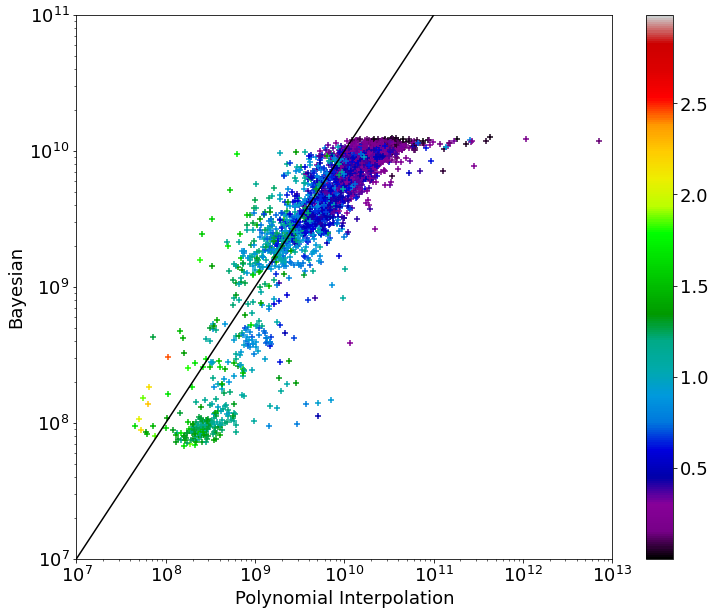

In [30]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'Polynomial Interpolation')
plt.ylabel(r'Bayesian')

In [ ]:
# plt.hist(10**pdfout['P_MEAN'][pdfout_ind])

In [ ]:
# plt.hist(10**np.asarray(parages)[r13_ind])

In [ ]:
# plt.hist(age_dist[100])

In [44]:
cat = Table()
col_id = Column(np.asarray(r13['APOGEE_ID']),name='APOGEE_ID')
col_age = Column(np.asarray(parages),name='AGE')
col_dev = Column(np.asarray(devs),name='AGE_ERR')
col_dist = Column(np.asarray(age_dist),name='DIST')

cat.add_column(col_id)
cat.add_column(col_age)
cat.add_column(col_dev)
cat.add_column(col_dist)

# cat.write('TEST_pca_ols_ages.fits',format='fits')#,overwrite=True)
# cat.write('TEST_pca_ols_ll.fits',format='fits',overwrite=True)

In [49]:
### Find all models

#transform data to new basis
# new_data = PCA(n_components=3).fit(data).transform(data)

#create new variables

# linear terms
x1 = parsec['logTe'] #new_data[:,0]
x2 = parsec['Ksmag'] #new_data[:,1]
x3 = parsec['MH'] #new_data[:,2]
x4 = parsec['logg']

# linear int
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x14 = np.multiply(x1,x4)

x23 = np.multiply(x2,x3)
x24 = np.multiply(x2,x4)

x34 = np.multiply(x3,x4)


# squares
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2
x4sq = x4**2

# cubes
# x1cu = x1**3
# x2cu = x2**3
# x3cu = x3**3


#find all possible models
models = []
models_str = []

all_var_str = ['x1','x2','x3','x4','x12','x13','x23','x24','x34','x1sq','x2sq','x3sq','x4sq']
all_var = [x1,x2,x3,x4,x12,x13,x23,x24,x34,x1sq,x2sq,x3sq,x4sq]

for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

### Fit All Models

import statsmodels.api as sm 

all_params = []
summaries = []
max_resid = []
mads = []
resids = []
predict = []
ll = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    summaries.append(model.summary())
    predictions = model.predict(pmodl)
    predict.append(predictions)
    residual = predictions - parsec['logAge']
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    mads.append(afunc.mad(residual))
    ll.append(model.llf)

KeyboardInterrupt: 

In [ ]:
print(summaries[np.asarray(ll).argmax()])
print(all_params[np.asarray(ll).argmax()])
print(models_str[np.asarray(ll).argmax()])


In [ ]:
print(summaries[np.asarray(mads).argmin()])
print(all_params[np.asarray(mads).argmin()])
print(models_str[np.asarray(mads).argmin()])

In [ ]:
def find_ages(z1,z2,z3,z4):
#     p = [9.77943559e+02,-5.25226935e+02,1.24426878e+01,-1.71063906e+01,-3.33360237e+00,4.80431454e+00,
#          -6.62127176e-02,3.89523313e-01,-8.75802774e-02,7.16174805e+01,-3.29702782e-02,1.69804627e-01,
#          -5.39563301e-01]
#     ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#             p[7]*np.multiply(z2,z4)+p[8]*np.multiply(z3,z4)+p[9]*(z1**2)+p[10]*(z2**2)+p[11]*(z3**2)+
#             p[12]*(z4**2))

#     p = [9.80851387e+02,-5.24981733e+02,1.26388036e+01,-1.48527724e+01,-3.38508869e+00,4.09636862e+00,
#          -8.83269488e-02,3.70451942e-01,7.13126367e+01,-3.11197530e-02,1.35549807e-01,-5.05326057e-01]
#     ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#             p[7]*np.multiply(z2,z4)+p[8]*(z1**2)+p[9]*(z2**2)+p[10]*(z3**2)+p[11]*(z4**2))

    p = [1.62773106e+02,-7.74432139e+01,5.79432496e+00,-8.21554113e-01,-6.31502225e+00,-8.53547492e-01,
         3.03422107e-01,-1.21805077e-02,-4.28300766e-01,-1.54961212e-03,1.08410088e+01,1.01740575e-01,
         7.55430356e-02,4.96225871e-01]
    ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*z4+p[5]*np.multiply(z1,z2)+p[6]*np.multiply(z1,z3)+
            p[7]*np.multiply(z2,z3)+p[8]*np.multiply(z2,z4)+p[9]*np.multiply(z3,z4)+p[10]*(z1**2)+p[11]*(z2**2)+
            p[12]*(z3**3)+p[13]*(z4**2))
    
#     p = [1.17993328e+02,-5.31336187e+01,5.45824048e+00,2.99452735e-01,-6.47520602e+00,-7.47386878e-01,
#          -8.83982229e-03,-4.45546306e-01,7.56108649e+00,1.04148096e-01,7.17546427e-02,5.20605161e-01]
#     ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*z4+p[5]*np.multiply(z1,z2)+p[6]*np.multiply(z1,z3)+
#             p[7]*np.multiply(z2,z3)+p[8]*np.multiply(z2,z4)+p[8]*(z1**2)+p[9]*(z2**2)+p[10]*(z3**2)+p[11]*(z4**2))
    return ages

In [ ]:
len(all_params[np.asarray(ll).argmax()])
len(models_str[np.asarray(ll).argmax()])

In [ ]:
age_dist = []

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(100):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
#         new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
#     zs = pca_transform.transform(np.asarray(np.squeeze(new)))

#     for l in range(len(zs)):
        noise_ages.append(find_ages(lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))

In [ ]:
plt.hist(parages)

In [ ]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)